<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2025notebooks/2025_0713CDP%2Bja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. 準備作業

<img src="https://raw.githubusercontent.com/project-ccap/project-ccap.github.io/refs/heads/master/2025figs/1998Zorzi_CDP_fig1.svg" style="width:49%;"><br/>
<p>Zorzi+(1998) Fig.1 Architecture of the model. The arrow means full connectivity between layers. Each box stand for a group of letters (26) or phonemes (44).</p>


<img src="https://raw.githubusercontent.com/project-ccap/project-ccap.github.io/refs/heads/master/2025figs/1998Zorzi_CDP_fig8.svg" width="49%;"><br/>
<p>Zorzi+(1998) Fig.8. Architecture of the model with the hidden layer pathway. In both the direct pathway and the mediated pathway the layers are fully connected (arrows).</p>

<img src="https://raw.githubusercontent.com/project-ccap/project-ccap.github.io/refs/heads/master/2025figs/1998Zorzi_fig10.svg" width="49%"><br/>
<p style="align-text:center">
Figure 10. Lexical and sublexical procedures in reading aloud, and their interaction in the phonological decision system, where the final phonological code is computed for articulation.
</p>


## 0.1 必要なライブラリの輸入

In [ ]:
%config InlineBackend.figure_format = 'retina'
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f'device:{device}')

# 必要なライブラリの輸入
from collections import OrderedDict
import sys
import os
import numpy as np
import operator
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# 全モデル共通使用するライブラリの輸入
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

HOME = os.environ['HOME']

from IPython import get_ipython
isColab =  'google.colab' in str(get_ipython())
print(f'isColab:{isColab}')

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

try:
    import ipynbname
except ImportError:
    !pip install ipynbname
    import ipynbname

FILEPATH = str(ipynbname.path()).split('/')[-1]
print(f'FILEPATH:{FILEPATH}')

try:
    import CDP_ja
except ImportError:
    !git clone https://github.com/ShinAsakawa/CDP_ja.git
    import CDP_ja

device:cuda:0
isColab:True
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 52.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=3a008411ebc2d271689bc78a5f02600238289125ecfe6b26545cd42f9f299caa
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00
FILEPATH:fileId=1aKXU1PV1iIZv69paqM1NvP2nRYTDQH8P
Cloning into 'CDP_ja'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 32 (delta 13), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 7.90 MiB | 11.21 MiB/s, done.
Resolving deltas: 100% (13/13), done.


## CDP_ja の読み込み (トークナイザ tokenizers, モデル)

* トークナイザ：モーラ分かち書き, 訓令式ローマ字, 学習漢字, 常用漢字
* モデル direct_TLA, indirect_TLA, combined_TLA

In [ ]:
%load_ext autoreload
%autoreload 2
from CDP_ja import mora_Tokenizer, kunrei_Tokenizer, gakushu_Tokenizer, joyo_Tokenizer

mora_tokenizer = mora_Tokenizer()
kunrei_tokenizer = kunrei_Tokenizer()
gakushu_tokenizer = gakushu_Tokenizer()
joyo_tokenizer = joyo_Tokenizer()

from CDP_ja import direct_TLA, indirect_TLA, combined_TLA
from CDP_ja import Seq2Seq_wAtt, Seq2Seq_woAtt
from CDP_ja import fit_an_epoch
from CDP_ja import eval_an_epoch
from CDP_ja import Psylex71_Dataset

モーラ分かち書きトークナイザ: mora_Tokenizer():
self.tokens:['<PAD>', '<EOW>', '<SOW>', '<UNK>', 'ァ', 'ア', 'ィ', 'イ', 'イェ', 'ゥ', 'ウ', 'ウィ', 'ウェ', 'ウォ', 'ェ', 'エ', 'ォ', 'オ', 'カ', 'ガ', 'キ', 'キャ', 'キュ', 'キョ', 'ギ', 'ギャ', 'ギュ', 'ギョ', 'ク', 'クァ', 'クィ', 'クェ', 'クォ', 'グ', 'グァ', 'ケ', 'ゲ', 'コ', 'ゴ', 'サ', 'ザ', 'シ', 'シェ', 'シャ', 'シュ', 'ショ', 'ジ', 'ジェ', 'ジャ', 'ジュ', 'ジョ', 'ス', 'ズ', 'ズィ', 'セ', 'ゼ', 'ソ', 'ゾ', 'タ', 'ダ', 'チ', 'チェ', 'チャ', 'チュ', 'チョ', 'ヂ', 'ヂャ', 'ヂュ', 'ヂョ', 'ッ', 'ツ', 'ツァ', 'ツィ', 'ツェ', 'ツォ', 'ヅ', 'テ', 'ティ', 'テュ', 'デ', 'ディ', 'デュ', 'ト', 'ド', 'ナ', 'ニ', 'ニェ', 'ニャ', 'ニュ', 'ニョ', 'ヌ', 'ネ', 'ノ', 'ハ', 'バ', 'パ', 'ヒ', 'ヒェ', 'ヒャ', 'ヒュ', 'ヒョ', 'ビ', 'ビャ', 'ビュ', 'ビョ', 'ピ', 'ピャ', 'ピュ', 'ピョ', 'フ', 'ファ', 'フィ', 'フェ', 'フォ', 'ブ', 'ブィ', 'プ', 'ヘ', 'ベ', 'ペ', 'ホ', 'ボ', 'ポ', 'マ', 'ミ', 'ミャ', 'ミュ', 'ミョ', 'ム', 'メ', 'モ', 'ヤ', 'ュ', 'ユ', 'ョ', 'ヨ', 'ラ', 'リ', 'リェ', 'リャ', 'リュ', 'リョ', 'ル', 'レ', 'ロ', 'ヮ', 'ワ', 'ヲ', 'ン', 'ヴ', 'ヴァ', 'ヴィ', 'ヴェ', 'ヴォ', 'ー']

    code:
        c1 = '[ウクスツヌフムユルグズヅブプヴ][ァィェォ]' #ウ段＋「ァ/ィ/ェ/ォ」
        c2 = '[イキシチニヒミリギジヂビピ]

# 1. NTT 日本語語彙特性 単語頻度データ psylex71 データセットの定義

In [ ]:
psylex71_dss={}  # データセットを複数格納するための辞書
inplen_min=2                  # 入力情報に与えるための最短単語文字長
#for inplen_max in [2,3,4,5]:  # 入力情報に与えるための最長単語文字長
for inplen_max in [2]:  # 入力情報に与えるための最長単語文字長

    if inplen_max == 2:       # 最初だけ全文字候補を出力
        display=True
    else:
        display=False

    psylex71_dss[inplen_max] = Psylex71_Dataset(
        inplen_min=2,
        inplen_max=inplen_max, # この値だけがループ内で変化する
        input_tokenizer=gakushu_tokenizer,  # 入力情報をトークン化するためのトークナイザ
        output_tokenizer=mora_tokenizer,    # 出力情報をトークン化するためのトークナイザ
        device=device,
        display=display)

    print(f'psylex71 最短文字長:{inplen_min}, 最長文字長:{inplen_max}',
          f'データセットサイズ (単語数):{psylex71_dss[inplen_max].__len__():7,d} 語')

Psylex71_Dataset(): inplen_min:2, inplen_max:2, len(self.dic):50666, maxlen_out:9
special_tokens: ['PAD', 'UNK', 'SOW', 'EOW']

psylex71 最短文字長:2, 最長文字長:2 データセットサイズ (単語数): 50,666 語


# 4. 訓練 (train) データセット，検証 (valid) データセット，検査 (test) データセットへ分割

## 4.1 データセットの選択

In [ ]:
# 以下の 2 つのデータセットは出力用トークナイザによって 2 つに分かれる。すなわち
# psylex_ds_mora: モーラ分かち書きされた情報を教師信号とする
# psylex_ds_kunrei: 訓令式ローマ字表記を更に, consonant + vowel 形式に分割した情報を教師信号とする
psylex71_ds_mora   = Psylex71_Dataset(input_tokenizer=gakushu_tokenizer, output_tokenizer=mora_tokenizer)
psylex71_ds_kunrei = Psylex71_Dataset(input_tokenizer=gakushu_tokenizer, output_tokenizer=kunrei_tokenizer)
psylex71_ds_o2o    = Psylex71_Dataset(input_tokenizer=gakushu_tokenizer, output_tokenizer=gakushu_tokenizer)
psylex71_ds_p2p    = Psylex71_Dataset(input_tokenizer=kunrei_tokenizer, output_tokenizer=kunrei_tokenizer)


Psylex71_Dataset(): inplen_min:2, inplen_max:2, len(self.dic):50666, maxlen_out:9
special_tokens: ['PAD', 'UNK', 'SOW', 'EOW']

Psylex71_Dataset(): inplen_min:2, inplen_max:2, len(self.dic):50666, maxlen_out:16
special_tokens: ['PAD', 'UNK', 'SOW', 'EOW']

Psylex71_Dataset(): inplen_min:2, inplen_max:2, len(self.dic):50666, maxlen_out:10
special_tokens: ['PAD', 'UNK', 'SOW', 'EOW']

Psylex71_Dataset(): inplen_min:2, inplen_max:2, len(self.dic):50666, maxlen_out:16
special_tokens: ['PAD', 'UNK', 'SOW', 'EOW']



## 4.2 データセットの分割,訓練,検査,検証データセット

In [ ]:
# データセットの分割,訓練,検査,検証データセット

# 乱数の種を設定
seed=42

# どちらのデータセットを用いるかを _ds に代入することで指定する
_ds = psylex71_ds_mora
#_ds = psylex71_ds_o2o
#_ds = psylex71_ds_p2p
#_ds = psylex71_ds_kunrei

# ここでは時間節約のため,全体のデータ数のうち 以下の割合だけデータを用いて検証を行う
#train_size = int(_ds.__len__() * 0.9)
#valid_size = int(_ds.__len__() * 0.1)
train_size = int(_ds.__len__() * 0.5)
valid_size = int(_ds.__len__() * 0.1)
resid_size = _ds.__len__() - train_size - valid_size

# 実際のデータ分割
train_ds, valid_ds, resid_size = torch.utils.data.random_split(
    dataset=_ds,
    lengths=(train_size, valid_size, resid_size),
    generator=torch.Generator().manual_seed(seed))

print(f'train_size:{train_size}')
print(f'valid_size:{valid_size}')

train_size:25333
valid_size:5066


## 4.3 バッチサイズの定義とデータローダの設定

In [ ]:
# ミニバッチサイズの定義
batch_size = 512

# データセットとミニバッチサイズを用いて PyTorch 用のデータローダを宣言
train_dl = torch.utils.data.DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(dataset=valid_ds, batch_size=batch_size, shuffle=False)

# 並列計算のための準備
def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts

# 訓練データセット用データローダ
train_dl = torch.utils.data.DataLoader(
    dataset=train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=_collate_fn)

# 検証データセット用のデータローダ
valid_dl = torch.utils.data.DataLoader(
    dataset=valid_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=_collate_fn)

print(f'train_ds.__len__():{train_ds.__len__()}')
print(f'valid_ds.__len__():{valid_ds.__len__()}')

train_ds.__len__():25333
valid_ds.__len__():5066


# 3. モデルの定義
## 3.1 TLA モデルの定義

## Transformer model の定義

In [ ]:
# from RAM import Transformer
# transformer = Transformer(src_vocab_size=len(gakushu_tokenizer.tokens),
#                           tgt_vocab_size=len(mora_tokenizer.tokens),
#                           model_dim=256,
#                           num_heads=4,
#                           num_layers=1,
#                           max_seq_length=psylex71_dss[2].maxlen_out,
#                           #max_seq_length=psylex71_ds.maxlen_out,
#                           dropout=0.,
#                           ff_dim=32,
#                           device=device)
# #).to(device)
# transformer.eval();

## 4.4 定義したモデルで動作チェック

In [ ]:
# モデルを宣言するために必要なハイパーパラメータを定義
_ds = train_ds                     # データセット
input_tokenizer=gakushu_tokenizer  # 入力データをトークン番号に変換するためのトークナイザ
output_tokenizer=mora_tokenizer    # 教師データをトークン番号に変換するためのトークナイザ
n_hid=256                          # 中間層のニューロン数

n_layers=1
bidirectional=False
out_f = 'sigmoid'

tla_seq2seq = Seq2Seq_wAtt(
    enc_vocab_size=len(input_tokenizer.tokens),
    dec_vocab_size=len(output_tokenizer.tokens),
    n_layers=n_layers,
    bidirectional=bidirectional,
    n_hid=n_hid).to(device)
print(tla_seq2seq.eval())

tla_indirect = indirect_TLA(
    inp_vocab_size=len(input_tokenizer.tokens),
    out_vocab_size=len(output_tokenizer.tokens),
    inp_len = 2 + 2,
    out_f = out_f,
    out_len = _ds.dataset.maxlen_out).to(device)
print(tla_indirect.eval())

tla_direct = direct_TLA(
    inp_vocab_size=len(input_tokenizer.tokens),
    out_vocab_size=len(output_tokenizer.tokens),
    inp_len = 2 + 2,
    out_f = out_f,
    out_len = _ds.dataset.maxlen_out).to(device)
print(tla_direct.eval())

tla_combined = combined_TLA(
    inp_vocab_size=len(input_tokenizer.tokens),
    out_vocab_size=len(output_tokenizer.tokens),
    inp_len = 2 + 2,
    out_f = out_f,
    out_len = _ds.dataset.maxlen_out).to(device)
print(tla_combined.eval())

# モデルを tla に代入
#tla = tla_vanilla
tla = tla_direct
tla = tla_combined
tla = tla_indirect
#tla = tla_seq2seq

# N 個のデータを実行してみる
N = 2
ids = np.random.permutation(_ds.__len__())[:N]  # データをシャフルして先頭の N 項目だけ ids に入れる
#print(type(psylex71_dss[2]))

for idx in ids:
    # データセットから返ってくる値は入力信号 inp と教師信号 tch
    inp, tch = _ds.__getitem__(idx)
    print(f'idx:{idx}:', f'inp:{inp}', f'tch:{tch}')

    # 入出力信号はトークン ID 番号であるため人間が読みやすいように変換して表示
    print(f'_ds.dataset.ids2inp({inp}):{_ds.dataset.ids2inp(inp)}')
    print(f'_ds.dataset.taregt_ids2target({tch}):{_ds.dataset.target_ids2target(tch)}')
    inp = pad_sequence(inp.unsqueeze(0), batch_first=True).to(device)
    tch = pad_sequence(tch.unsqueeze(0), batch_first=True).to(device)

    # モデルにデータを与えて出力を得る
    outs = tla(inp, tch)

    # 結果の表示
    print('教師:', _ds.dataset.target_ids2target([idx.cpu().numpy() for idx in tch.squeeze(0)]), end=": ")
    print('教師 ids:', [int(_tch.cpu().numpy()) for _tch in tch.squeeze(0)])
    print('出力 ids:', [int(_out.argmax().cpu().numpy()) for _out in outs[0]], end="\n===\n")

Seq2Seq_wAtt(
  (encoder_emb): Embedding(1189, 256, padding_idx=0)
  (decoder_emb): Embedding(155, 256, padding_idx=0)
  (encoder): LSTM(256, 256, batch_first=True)
  (decoder): LSTM(256, 256, batch_first=True)
  (combine_layer): Linear(in_features=512, out_features=256, bias=True)
  (out_layer): Linear(in_features=256, out_features=155, bias=True)
)
indirect_TLA(
  (emb_layer): Embedding(1189, 155, padding_idx=0)
  (emb_transform): Linear(in_features=620, out_features=1395, bias=True)
  (out_f): Sigmoid()
)
direct_TLA(
  (out_layer): Linear(in_features=4756, out_features=1395, bias=True)
  (out_f): Sigmoid()
)
combined_TLA(
  (emb_layer): Embedding(1189, 155, padding_idx=0)
  (emb_transform): Linear(in_features=620, out_features=1395, bias=True)
  (out_layer): Linear(in_features=4756, out_features=1395, bias=True)
  (out_f): Sigmoid()
)
idx:2965: inp:tensor([  2, 117, 175,   1], device='cuda:0') tch:tensor([  2,  39, 146,   1,   0,   0,   0,   0,   0], device='cuda:0')
_ds.dataset.ids

In [ ]:
from asa_pytorch_lstm import NaiveLSTM
#print(dir(NaiveLSTM))

class vanilla_LM(torch.nn.Module):
    def __init__(self,
                 inp_vocab_size:int=None, # len(psylex71_ds.input_tokenizer.tokens),
                 out_vocab_size:int=None, # len(psylex71_ds.output_tokenizer.tokens),
                 #inp_len:int=None, # maxlen_inp,
                 #out_len:int=None, # psylex71_ds.maxlen_out,
                 n_hid:int=512,
                 device:str='cpu'):
        super().__init__()
        self.inp_vocab_size=inp_vocab_size
        #self.inp_len=inp_len
        self.out_vocab_size=out_vocab_size
        #self.out_len=out_len
        self.n_hid=n_hid

        self.emb_layer = torch.nn.Linear(in_features=inp_vocab_size, out_features=n_hid).to(device)
        self.emb_outf = torch.nn.Tanh()
        self.out_outf = torch.nn.Sigmoid()
        self.lstm = NaiveLSTM(n_inp=n_hid, n_hid=n_hid).to(device)
        self.out_layer = torch.nn.Linear(in_features=n_hid, out_features=out_vocab_size).to(device)

    def forward(self, X):
        '''互換性のため Y を入力としているが実際には使っていない'''

        #X = X.float()               # ワンホットベクトルは整数 int64 なので浮動小数点に変換
        # 入力 X はトークン ID リストであるので，ワンホットベクトル化する
        X = torch.nn.functional.one_hot(X, num_classes=self.inp_vocab_size)

        #print(X)
        #sys.exit()
        X = X.float()
        X = self.emb_layer(X)       # 埋め込み層への信号伝搬
        X = self.emb_outf(X)        # 埋め込み層の非線形変換

        X, (h, c) = self.lstm(X)

        X = self.out_layer(X)       # 出力層への信号伝搬
        X = self.out_outf(X)        # 出力層での非線形変換

        return X

lm = vanilla_LM(inp_vocab_size=len(input_tokenizer.tokens),
                out_vocab_size=len(output_tokenizer.tokens),
                n_hid=1024,
                device=device)
lm.eval()

# 5. 学習

## 5.1 訓練に用いるモデルを再定義

In [ ]:
# 以下では 3 つのモデルを定義して比較している
ds = train_ds
n_layers=1
bidirectional=False
n_hid=512
n_hid=1024
#n_hid=128
# n_hid=2048
# n_hid=4096

input_tokenizer=gakushu_tokenizer
output_tokenizer=mora_tokenizer

out_f = 'tanh'
out_f = 'softmax'
# otf_f = 'none'
out_f = 'sigmoid'

tla_combined = combined_TLA(inp_vocab_size=len(input_tokenizer.tokens),
                            out_vocab_size=len(output_tokenizer.tokens),
                            inp_len=2+2,
                            out_len=ds.dataset.maxlen_out,
                            out_f = out_f,
                            device=device)
print(tla_combined.eval())

tla_direct = direct_TLA(inp_vocab_size=len(input_tokenizer.tokens),
                        out_vocab_size=len(output_tokenizer.tokens),
                        inp_len=2+2,
                        out_len=ds.dataset.maxlen_out,
                        out_f = out_f,
                        device=device)
print(tla_direct.eval())


tla_indirect = indirect_TLA(inp_vocab_size=len(input_tokenizer.tokens),
                            out_vocab_size=len(output_tokenizer.tokens),
                            inp_len=2+2,
                            out_len=ds.dataset.maxlen_out,
                            out_f = out_f,
                            device=device)
print(tla_indirect.eval())


tla_seq2seq = Seq2Seq_wAtt(enc_vocab_size=len(input_tokenizer.tokens),
                           dec_vocab_size=len(output_tokenizer.tokens),
                           n_layers=n_layers,
                           bidirectional=bidirectional,
                           n_hid=n_hid).to(device)
print(tla_seq2seq.eval())

tla_seq2seq0 = Seq2Seq_woAtt(enc_vocab_size=len(input_tokenizer.tokens),
                             dec_vocab_size=len(output_tokenizer.tokens),
                             n_layers=n_layers,
                             bidirectional=bidirectional,
                             n_hid=n_hid).to(device)
print(tla_seq2seq0.eval())

combined_TLA(
  (emb_layer): Embedding(1189, 155, padding_idx=0)
  (emb_transform): Linear(in_features=620, out_features=1395, bias=True)
  (out_layer): Linear(in_features=4756, out_features=1395, bias=True)
  (out_f): Sigmoid()
)
direct_TLA(
  (out_layer): Linear(in_features=4756, out_features=1395, bias=True)
  (out_f): Sigmoid()
)
indirect_TLA(
  (emb_layer): Embedding(1189, 155, padding_idx=0)
  (emb_transform): Linear(in_features=620, out_features=1395, bias=True)
  (out_f): Sigmoid()
)
Seq2Seq_wAtt(
  (encoder_emb): Embedding(1189, 1024, padding_idx=0)
  (decoder_emb): Embedding(155, 1024, padding_idx=0)
  (encoder): LSTM(1024, 1024, batch_first=True)
  (decoder): LSTM(1024, 1024, batch_first=True)
  (combine_layer): Linear(in_features=2048, out_features=1024, bias=True)
  (out_layer): Linear(in_features=1024, out_features=155, bias=True)
)
Seq2Seq_woAtt(
  (encoder_emb): Embedding(1189, 1024, padding_idx=0)
  (decoder_emb): Embedding(155, 1024, padding_idx=0)
  (encoder): LSTM(1

## 5.2 実際の訓練

In [ ]:
model1 = tla_seq2seq
model2 = tla_seq2seq0
model3 = tla_direct
model4 = tla_indirect
model5 = tla_combined

loss_f = torch.nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
# 学習率リストとエポック数の定義
iter_params = [(1e-3, 2), (1e-4, 2), (1e-5, 2)]
iter_params = [(1e-3, 20)]
iter_params = [(1e-3, 5)]
iter_params = [(1e-2, 20)]
iter_params = [(1e-1, 50), (1e-2,20), (1e-3,20), (1e-4,10)]
iter_params = [(1e-3, 100)]
#iter_params = [(1e-3, 30)]
# iter_params = [(1e-4, 10)]
# iter_params = [(1e-2, 50), (1e-3, 50), (1e-4, 10)]

try:
    isinstance(results,list)
except:
    results = [{}, {}, {}, {}]

# 途中結果を印字するタイミング
#interval = 3
interval = 1
#interval = 10

for (lr, epochs) in iter_params: # 学習率とエポック数を定義済のリストに従って変化させる

    # 最適化関数の学習率を設定
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)
    optimizer3 = torch.optim.Adam(model3.parameters(), lr=lr)
    optimizer4 = torch.optim.Adam(model4.parameters(), lr=lr)
    optimizer5 = torch.optim.Adam(model5.parameters(), lr=lr)

    print(f'lr:{lr}, epochs:{epochs}')
    # エポック数だけ学習を行う
    for epoch in range(epochs):
        print(f"エポック:{epoch+1:3d}")

        #for N, (model, optimizer) in enumerate([(model1,optimizer1)]):
        #for N, (model, optimizer) in enumerate([(model3,optimizer3)]):
        for N, (model, optimizer) in enumerate([(model3,optimizer3), (model4,optimizer4), (model5,optimizer5)]):
        #for N, (model, optimizer) in enumerate([(model2,optimizer2), (model1,optimizer1), (model0,optimizer0)]):
        #for N, (model, optimizer) in enumerate([(model1,optimizer1), (model2,optimizer2)]):

            # 1 エポックの検証を行う

            is_seq2seq = 'Seq2Seq' in str(type(model))
            out = eval_an_epoch(model=model, _dl=valid_dl, loss_f=loss_f, is_seq2seq=is_seq2seq, device=device)
            if (epoch % interval) == 0:
                print(f"モデル {N} ",
                      f"検証損失値={out['sum_loss']:10.3f}",
                      f"正解率={out['P']:5.3f}",
                      f"({out['count']:5d}/{out['N']:5d})",
                      end="\t")

            if not 'valid_loss' in results[N]:
                results[N]['valid_loss'] = [out['sum_loss']]
            else:
                results[N]['valid_loss'].append(out['sum_loss'])
            if not 'valid_P' in results[N]:
                results[N]['valid_P'] = [out['P']]
            else:
                results[N]['valid_P'].append(out['P'])


            # 1 エポックの訓練を行う
            out = fit_an_epoch(model=model, _dl=train_dl, loss_f=loss_f, optimizer=optimizer, is_seq2seq=is_seq2seq, device=device)
            if (epoch % interval) == 0:
                print(f"学習損失値={out['sum_loss']:10.3f}",
                      f"正解率={out['P']:5.3f}",
                      f"({out['count']:5d}/{out['N']:5d})",
                      end="\t")

            if not 'train_loss' in results[N]:
                results[N]['train_loss'] = [out['sum_loss']]
            else:
                results[N]['train_loss'].append(out['sum_loss'])
            if not 'train_P' in results[N]:
                results[N]['train_P'] = [out['P']]
            else:
                results[N]['train_P'].append(out['P'])

            if (epoch % interval) == 0:
                print()

lr:0.001, epochs:100
エポック:  1
モデル 0  検証損失値= 21021.682 正解率=0.262 ( 1327/ 5066)	学習損失値=102802.078 正解率=0.462 (11701/25333)	
モデル 1  検証損失値= 20861.667 正解率=0.017 (   85/ 5066)	学習損失値=103991.366 正解率=0.020 (  516/25333)	
モデル 2  検証損失値= 20843.211 正解率=0.040 (  204/ 5066)	学習損失値=103901.627 正解率=0.044 ( 1126/25333)	
エポック:  2
モデル 0  検証損失値= 21021.921 正解率=0.262 ( 1329/ 5066)	学習損失値=102802.047 正解率=0.462 (11708/25333)	
モデル 1  検証損失値= 20863.063 正解率=0.017 (   87/ 5066)	学習損失値=103988.886 正解率=0.020 (  518/25333)	
モデル 2  検証損失値= 20844.127 正解率=0.041 (  208/ 5066)	学習損失値=103899.265 正解率=0.045 ( 1128/25333)	
エポック:  3
モデル 0  検証損失値= 21021.872 正解率=0.262 ( 1327/ 5066)	学習損失値=102802.028 正解率=0.462 (11702/25333)	
モデル 1  検証損失値= 20864.888 正解率=0.018 (   90/ 5066)	学習損失値=103987.606 正解率=0.021 (  542/25333)	
モデル 2  検証損失値= 20844.808 正解率=0.041 (  207/ 5066)	学習損失値=103898.048 正解率=0.045 ( 1136/25333)	
エポック:  4
モデル 0  検証損失値= 21021.832 正解率=0.262 ( 1328/ 5066)	学習損失値=102802.009 正解率=0.462 (11707/25333)	
モデル 1  検証損失値= 20865.423 正解率=0.018 (   91/ 5

## 学習曲線の描画

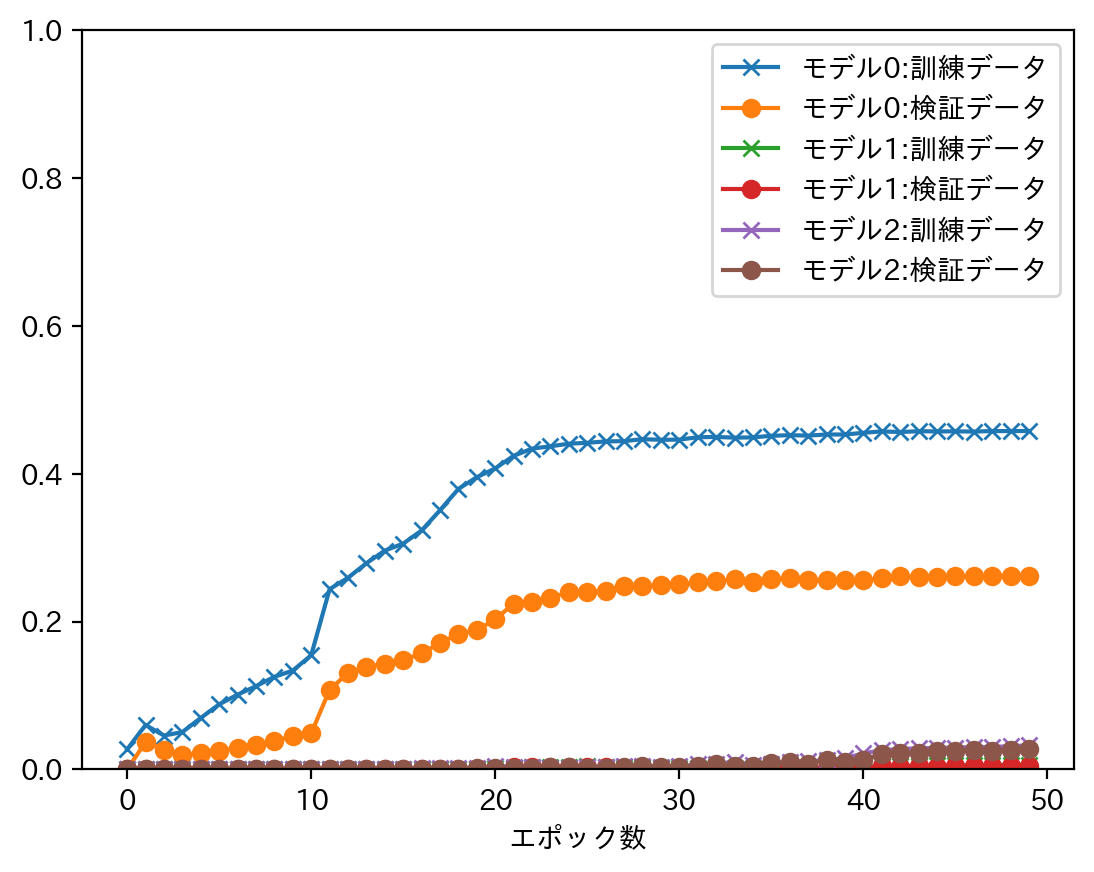

In [ ]:
for i in range(3):
    #plt.plot(results[i]['train_loss'], 'x-', label=f'{i}:訓練データ')
    #plt.plot(results[i]['valid_loss'], 'o-', label=f'{i}:検証データ')
    plt.plot(results[i]['train_P'], 'x-', label=f'モデル{i}:訓練データ')
    plt.plot(results[i]['valid_P'], 'o-', label=f'モデル{i}:検証データ')

plt.legend()
plt.xlabel('エポック数')
plt.ylim(0,1)
plt.show()

#print(results)


# 読めなかった単語を調べてみる

In [ ]:
# 読めなかった単語を調べてみる

loss_f = torch.nn.CrossEntropyLoss(ignore_index=-1)

cr = 0
model = tla_seq2seq0.eval()
for i, (inp, tch) in enumerate(valid_ds):
    out = model(inp,tch)
    out_ids = out.argmax(dim=1)
    yesno = (((tch==out_ids) * 1).sum()  == len(tch)).detach().cpu().numpy()
    #if yesno == True:
    #    cr += 1
    if yesno == False:
        print(f'入力:{"".join(c for c in gakushu_tokenizer.decode(inp)).replace('<SOW>','').replace('<EOW>','')}',
              f'出力:{"".join(c for c in mora_tokenizer.decode(out_ids.detach().cpu().numpy())).replace('<PAD>','').replace('<SOW>','').replace('<EOW>','')}',
              f'正解:{"".join(c for c in mora_tokenizer.decode(tch)).replace('<PAD>','').replace('<SOW>','').replace('<EOW>','')}',
              end=" "
             )
        loss = loss_f(out,tch)
        loss.backward()
        print(f'損失値:{loss.item():.3f}') # , type(loss.item()), loss)
    #if cr >= 30:
    #    break


In [ ]:
def eval_a_word(model:torch.nn.Module=tla_seq2seq0,
                wrd:str="",
                input_tokenizer=gakushu_tokenizer,
                output_tokenizer=mora_tokenizer):
    inps = torch.LongTensor(input_tokenizer(wrd))
    inps = torch.LongTensor([input_tokenizer.tokens.index('<SOW>')]+input_tokenizer(wrd)+[input_tokenizer.tokens.index('<EOW>')])

    #print(wrd, inps)

    inps = pad_sequence(inps.unsqueeze(0), batch_first=True).to(device)
    #out0 = pad_sequence(torch.LongTensor([output_tokenizer.tokens.index('<SOW>')]).unsqueeze(0)).to(device)
    #outs = model(inps,out0)
    #out_ch = output_tokenizer.decode(outs.squeeze(0).argmax(dim=1))
    #print(out_ch, outs.argmax(dim=1))
    #sys.exit()

    tchs = pad_sequence(torch.LongTensor([[  2,  54, 148,  56,  10,   1,   0]]),batch_first=True).to(device)
    #tchs = pad_sequence(torch.LongTensor([[  2,  0]]),batch_first=True).to(device)
    outs = model(inps,tchs)
    print(f'inps:{inps}')
    print(f'tchs:{tchs}')
    print(f'outs:{outs.squeeze(0).argmax(dim=1)}')
    sys.exit()
    return inp, wrd, out0, outs

model = tla_seq2seq0.eval()
inp, wrd, out0, outs = eval_a_word(model=model, wrd='戦争')
# print(inp,wrd, out0, outs.squeeze(0).argmax(dim=1))
# sys.exit()


In [ ]:
wrd='戦争'

if wrd in psylex71_ds_mora.inputs:
    idx = psylex71_ds_mora.inputs.index(wrd)
    print(idx, wrd, psylex71_ds_mora.getitem(idx), psylex71_ds_mora.__getitem__(idx))

output_tokenizer.tokens.index('')

#sys.exit()
def eval_a_word(model:torch.nn.Module=tla_seq2seq0,
                wrd:str="",
                input_tokenizer=gakushu_tokenizer,
                output_tokenizer=mora_tokenizer):
    inps = torch.LongTensor(input_tokenizer(wrd))
    print(wrd, inps)
    inps = pad_sequence(inps.unsqueeze(0), batch_first=True).to(device)
    print(wrd, inps)
    return inp, wrd

eval_a_word(model=tla_seq2seq0, wrd=wrd)
sys.exit()

inps,tchs = valid_ds.__getitem__(8)
inps = pad_sequence(inps.unsqueeze(0), batch_first=True).to(device)
tchs = pad_sequence(tchs.unsqueeze(0), batch_first=True).to(device)

# inps, tchs = next(iter(valid_dl))
# inps = pad_sequence(inps, batch_first=True).to(device)
# tchs = pad_sequence(tchs, batch_first=True).to(device)
model.eval()
outs = model(inps,tchs)
print(inps.size(), tchs.size(), outs.size()) # torch.Size([1024, 2]) torch.Size([1024, 9]) torch.Size([1024, 9, 155])


for inp, tch, out in zip(inps, tchs, outs):
    print(inp.size(), tch.size(), out.size())
    print(gakushu_tokenizer.decode(inp), mora_tokenizer.decode(tch), out.argmax(dim=1))
    print(mora_tokenizer.decode(out.argmax(dim=1).detach().cpu().numpy()))



In [ ]:
inp = '戦争'
tch = 'センソウ'
inp_ids = torch.LongTensor(gakushu_tokenizer(inp)).unsqueeze(0)
tch_ids = torch.LongTensor([mora_tokenizer.tokens.index('<SOW>')]).unsqueeze(0)
model = tla_seq2seq0
inps = pad_sequence(inp_ids, batch_first=True).to(device)
tchs = pad_sequence(tch_ids, batch_first=True).to(device)
outs = model(inps, tchs)
print(outs.size(), outs.squeeze(0).argmax(), mora_tokenizer(tch))
print(mora_tokenizer.decode([outs.squeeze(0).argmax()]))

tch_ids = torch.LongTensor(mora_tokenizer('センソウ')).unsqueeze(0)
tch_ids = mora_tokenizer('センソウ')
tch_ids = [mora_tokenizer.tokens.index('<SOW>')]+tch_ids+[mora_tokenizer.tokens.index('<EOW>')]
tch_ids = torch.LongTensor(tch_ids).unsqueeze(0)
outs = model(inps, tchs)
print(tch_ids, outs.squeeze(0).argmax())

# # 正解のカウント
# out_ids = [out.argmax(dim=1) for out in outs]
# for tch, out in zip(tchs[:], out_ids[:]):
# yesno = ((tch==out) * 1).sum().cpu().numpy() == len(tch)
# count += 1 if yesno else 0



In [ ]:
#train_ds.dataset.output_tokenizer
results[0]

In [ ]:
model = tla_seq2seq0
model = model2
_ds = valid_ds
with torch.no_grad():
    for i in range(3):
    #for i in range(_ds.__len__()):

        idx = _ds.indices[i]
        inp, tgt = _ds.dataset.__getitem__(idx)
        inp_ids = pad_sequence(inp.unsqueeze(0), batch_first=True).to(device)
        tgt_ids = pad_sequence(tgt.unsqueeze(0), batch_first=True).to(device)

        enc_emb = model.encoder_emb(inp_ids)
        enc_out, (hnx, cnx) = model.encoder(enc_emb)

        dec_inp = torch.tensor([_ds.dataset.output_tokenizer.tokens.index('<SOW>')], device=device)
        dec_inp = model.decoder_emb(dec_inp).unsqueeze(0)
        dec_state = (hnx, cnx)

        print(f'inp:{inp.cpu().numpy()}',
              f'{"".join(c for c in _ds.dataset.ids2inp(inp.cpu().numpy()))}',
              f'{tgt.cpu().numpy()}',
              f'{"".join(c for c in _ds.dataset.target_ids2target(tgt.cpu().numpy()))}'
             )

        for _i in range(len(tgt_ids[0][1:])):
        #for i in range(len(tgt_ids[0])):

            dec_out, dec_state = model.decoder(dec_inp, dec_state)
            dec_out = dec_out.argmax().unsqueeze(0)
            dec_inp = model.decoder_emb(dec_out).unsqueeze(0)
            # print(f'_i:{_i}',
            #        f'dec_out:{dec_out.detach().cpu().numpy()}',
            #        f'tgt_ids[0][{_i+1}]:{tgt_ids[0][_i+1]}')

        out_ = model(inp_ids,tgt_ids)
        out_ids =  out_.squeeze(0).argmax(dim=1).detach().cpu().numpy()
        out_tokens = "".join(c for c in psylex71_ds.target_ids2target(out_ids))
        print(out_tokens)

        #inp, tgt = _ds.__getitem__(i)
        #inp_ids = inp

        #print(f'out_.squeeze(0).argmax(dim=1){out_.squeeze(0).argmax(dim=1).detach().cpu().numpy()}')


In [ ]:
out_ids = out_.squeeze(0).argmax(dim=1).detach().cpu().numpy()
print(_ds.dataset.target_ids2target(out_ids), out_ids)
#print(psylex71_ds.target_ids2target(out_ids), out_ids)

out_tokens = "".join(c for c in _ds.dataset.target_ids2target(out_ids))
out_tokens
inp, tgt = _ds.__getitem__(2)
inp_ids = _ds.dataset.ids2inp(inp)
inp_ids

In [ ]:
model = tla_seq2seq
with torch.no_grad():
    for i in range(_ds.__len__()):
        inp, tgt = chihaya_ds.__getitem__(i)
        # print(f'インプット:{"".join(c for c in chihaya_ds.ids2tkn(inp))}') #i].cpu().numpy()))}')
        # print(f'ターゲット:{"".join(c for c in chihaya_ds.ids2tkn(tgt))}') #n(c for c in chihaya_ds.ids2tkn(tgt_ids[i].cpu().numpy()))}')

        inp_ids = pad_sequence(inp.unsqueeze(0), batch_first=True).to(device)
        tgt_ids = pad_sequence(tgt.unsqueeze(0), batch_first=True).to(device)
        #inp_ids = torch.as_tensor(inp, device=device)
        #tgt_ids = torch.as_tensor(tgt, device=device)
        enc_out, enc_state = model.encoder(inp_ids)
        #dec_out, dec_state = decoder(tgt_ids, enc_state)

        dec_ids = dec_out.argmax(dim=1).detach().cpu().numpy()
        print(f'len(dec_ids):{len(dec_ids)}')
        print("".join(c for c in chihaya_ds.ids2tkn(dec_ids)))

        dec_inp = torch.tensor([chihaya_ds.chihaya_tokens.index('<SOS>')], device=device)
        dec_inp = tgt_ids[0].unsqueeze(0)
        for i in range(len(dec_ids)):
            dec_out, dec_state = decoder(dec_inp, dec_state)
            #print(dec_out.size(), dec_out.argmax().cpu().numpy(), type(dec_out.argmax())) #, dec_out)

            if teacher_forcing:
                dec_inp = tgt_ids[i].unsqueeze(0)
            else:
                dec_inp = dec_out.argmax().unsqueeze(0) # .clone().detach()

            #dec_inp = dec_out.argmax().unsqueeze(0).clone().detach()
            print(f'({dec_inp.cpu().numpy()}',
                  f'{chihaya_ds.chihaya_tokens[dec_inp.cpu().numpy()[0]]})', end=" ") # , type(dec_inp)) # , dec_inp)
            #print(dec_inp.size(), dec_inp.argmax().cpu().numpy(), type(dec_inp.argmax())) # , dec_inp)
            #sys.exit()
        sys.exit()


# vect2seq model の定義

In [ ]:
class Vec2Seq(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # 単語の意味ベクトル a.k.a 埋め込み表現 を decoder の中間層に接続するための変換層
        # 別解としては，入力層に接続する方法があるが，それはまた別実装にする
        self.enc_transform_layer = nn.Linear(
            in_features=sem_dim,
            out_features=n_hid)
        self.decoder_emb = nn.Embedding(
            num_embeddings=dec_vocab_size,
            embedding_dim=n_hid,
            padding_idx=0)

        self.decoder = nn.LSTM(
            input_size=n_hid,
            hidden_size=n_hid,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional)

        # 最終出力層
        self.bi_fact = 2 if bidirectional else 1
        self.out_layer = nn.Linear(self.bi_fact * n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):
        enc_emb = self.enc_transform_layer(enc_inp)
        hnx, cnx = enc_emb.clone(), enc_emb.clone()
        hnx = hnx.unsqueeze(0)
        cnx = cnx.unsqueeze(0)

        if self.bi_fact == 2:
            hnx = hnx.repeat(2)
            cnx = cnx.repeat(2)

        dec_emb = self.decoder_emb(dec_inp)

        batch_size = enc_inp.size(0)
        exp_hid_size = self.decoder.get_expected_hidden_size(enc_inp, batch_sizes=[batch_size])
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        return self.out_layer(dec_out)

# 以下確認作業
# ds = train_ds
# tla_vec2seq = Vec2Seq(
#     sem_dim=n_layers,
#     dec_vocab_size=len(mora_tokenizer.tokens),
#     n_hid=n_hid,
#     n_layers=n_layers,
#     bidirectional=bidirectional).to(device)
# print(tla_vec2seq.eval())

# Jalex の読み込み

In [ ]:
import pandas as pd
try:
    import jaconv
except:
    !pip install jaconv --upgrade
    import jaconv
# Mecab を使ってヨミを得るために MeCab を import する
from ccap.mecab_settings import wakati, yomi #, parser

jalex_base = os.path.join(HOME, 'study/2025_2014jalex')
jalex_xls_fname = 'JALEX.xlsx'
jalex_fname = os.path.join(jalex_base, jalex_xls_fname)
jalex_DF = pd.read_excel(jalex_fname)
jalex_DF
jalex_words = jalex_DF['目標語']
print(len(jalex_words))

jalex_dic = OrderedDict()
for wrd in jalex_words:
    if not wrd in jalex_dic:
        _yomi = yomi(wrd).strip()
        _wakati = wakati(wrd).strip()
        _mora = mora_tokenizer.wakachi(_yomi)
        _kunrei = kunrei_tokenizer.wakachi(_yomi)
        _hira_yomi = jaconv.kata2hira(_yomi)
        _julius = jaconv.hiragana2julius(_hira_yomi).split(' ')

        jalex_dic[wrd] = {'ヨミ':_yomi, 'モーラ':_mora, '訓令':_kunrei, 'ユリウス':_julius} # , 'Jalex':jalex_DF['wrd']}
        print(jalex_dic[wrd])
        sys.exit()

In [ ]:
#jalex_DF[jalex_DF.iloc('目標語'=='あさって')]
jalex_DF['目標語'].str.contains('あさって')
#print(dir(jaconv))
#help(jaconv.normalize)

## 0.2 NTT 日本語語彙特性 単語頻度データ psylex71.txt のダウンロード

In [ ]:
# if isColab:
#     !pip install googledrivedownloader==0.4
#     from google_drive_downloader import GoogleDriveDownloader as gdd
#     import os

#     # 共有ファイルのIDを指定
#     file_id = '1eBJDN392BsUckg5LBFbbw5KT9PCsmnxI' # 'psylex71utf8_.txt
#     # https://drive.google.com/file/d/1eBJDN392BsUckg5LBFbbw5KT9PCsmnxI/view?usp=drive_link

#     # 保存したい場所とファイル名を指定\n",
#     # 例: /content/ ディレクトリに original_file_name.拡張子 という名前で保存\n",
#     destination_path = '/content/psylex71utf8_.txt' # ファイルの拡張子を適切に設定してください\n",
#     try:
#         print(f"ファイルのダウンロードを開始します (ファイルID: {file_id})...")
#         gdd.download_file_from_google_drive(file_id=file_id,
#                                             dest_path=destination_path)
#                                             # unzip=True if file_id is for a zip file):
#         print(f"ファイルのダウンロードが完了しました。'{destination_path}' に保存されました。")

#         # ダウンロードしたファイルを読み込む例 (テキストファイルの場合)
#         if os.path.exists(destination_path):
#             print("ダウンロードしたファイルの内容 (最初の数行):")
#             with open(destination_path, 'r') as f:
#                 # ファイルの内容を表示 (例: 最初の5行)
#                 for i in range(5):
#                     line = f.readline()
#                     if not line:
#                         break
#                     print(line.strip())
#         else:
#             print(f"エラー: ダウンロード先のファイル '{destination_path}' が見つかりません。")

#     except Exception as e:
#         print(f"ファイルのダウンロード中にエラーが発生しました: {e}")

In [ ]:
import torch
class Psylex71_Dataset_Original(torch.utils.data.Dataset):
    '''ニューラルネットワークモデルに Psylex71 を学習させるための PyTorch 用データセットのクラス'''

    def __init__(self,
                 dic=Psylex71,
                 grph_list=grph_list,
                 phon_list=mora_list,
                 special_tokens=special_tokens,
                 maxlen_phon=maxlen_phon +2, # ＋2 しているのは <SOW>,<EOW> という 2 つのスペシャルトークンを付加するため
                 device=device):
        super().__init__()
        self.dic = dic
        self.special_tokens = special_tokens
        self.maxlen_phon = maxlen_phon
        self.grph_list = grph_list
        self.phon_list = phon_list
        self.input_cands = grph_list
        #self.target_cands = special_tokens + phon_list
        self.target_cands = special_tokens + mora_list
        # self.inputs = [v['単語'] for v in dic.values()]
        # self.targets = [v['ヨミ'] for v in dic.values()]
        # self.targets = [v['モーラ'] for v in dic.values()]
        self.inputs = [v['単語'] for v in dic.values()]
        self.targets = [v['ヨミ'] for v in dic.values()]
        self.targets = [v['モーラ'] for v in dic.values()]
        self.device = device

    def __len__(self):
        return len(self.dic)

    def __getitem__(self, idx):
        inp, tgt = self.inputs[idx], self.targets[idx]

        # 入力信号にも <SOW>, <EOW> トークンを付与する場合
        #inp = [self.input_cands.index('<SOW>')]  + [self.input_cands.index(x) for x in inp]  + [self.input_cands.index('<EOW>')]

        # 入力信号にはスペシャルトークンを付与しない場合
        inp = [self.input_cands.index(x) for x in inp]

        # ターゲット (教師)信号 には <SOW>, <EOW> を付与する
        tgt = [self.target_cands.index('<SOW>')] + [self.target_cands.index(x) for x in tgt] + [self.target_cands.index('<EOW>')]

        while len(tgt) < self.maxlen_phon:
            tgt = tgt + [self.target_cands.index('<PAD>')]

        inp, tgt = torch.LongTensor(inp), torch.LongTensor(tgt)
        inp, tgt = inp.to(self.device), tgt.to(self.device)
        return inp, tgt

    def getitem(self, idx):
        #inp, tgt = self.inputs[idx], self.targets[idx]
        wrd = self.inputs[idx]
        phn = self.targets[idx]
        return wrd, phn

    def ids2argmax(self, ids):
        out = np.array([torch.argmax(idx).numpy() for idx in ids], dtype=np.int32)
        return out

    def ids2tgt(self, ids):
        #out = [self.target_cands[torch.argmax(idx)] for idx in ids]
        out = [self.target_cands[idx - len(self.special_tokens)] for idx in ids]
        return out

    def ids2inp(self, ids):
        out = [self.input_cands[idx] for idx in ids]
        #out = [self.input_cands[idx - len(self.special_tokens)] for idx in ids]
        return out

    def target_ids2target(self, ids:list):
        ret = []
        for idx in ids:
            if idx == self.target_cands.index('<EOW>'):
                return ret+['<EOW>']
            ret.append(self.target_cands[idx])
        return ret